In [1]:
#standard imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#import tensorflow and keras
import tensorflow as tf
from tensorflow import keras

import seaborn as sns
sns.set(style= "darkgrid", color_codes = True)
from tensorflow.keras.applications import VGG16

#import generic model class
from tensorflow.keras import Model, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.metrics import roc_curve, auc, confusion_matrix
from tensorflow.keras.preprocessing.image import  load_img, ImageDataGenerator
from keras.optimizers import RMSprop,Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

#import random
import random as rn
from random import randrange

#Usefull imports from kaggle
import glob
from PIL import Image
import os
import cv2

#function for fast generation of training and test set from data
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.layers import AvgPool2D




2023-08-22 16:54:36.906615: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-22 16:54:36.997228: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-22 16:54:36.998063: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-22 16:54:37.891618: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Define image size and other parameterst 

path = '/home/giacomo/git/Tittarelli_Giacomo_RetiNeurali/chest_xray/chest_xray/'
dimension = 50
img_width, img_height = dimension, dimension
batchsize = 32
num_of_class = 2

train = keras. utils.image_dataset_from_directory(
    directory= path + 'train',
    labels='inferred',
    label_mode='categorical',
    batch_size=batchsize,
    image_size=(img_width, img_height))

validation = keras. utils.image_dataset_from_directory(
    directory= path + 'val',
    labels='inferred',
    label_mode='categorical',
    batch_size=batchsize,
    image_size=(img_width, img_height))

test = keras. utils.image_dataset_from_directory(
    directory= path + 'test',
    labels='inferred',
    label_mode='categorical',
    batch_size=batchsize,
    image_size=(img_width, img_height))



Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [3]:
# define paths
train_normal_dir = path + 'train/NORMAL/'
train_pneu_dir = path + 'train/PNEUMONIA/'

test_normal_dir = path + 'test/NORMAL/'
test_pneu_dir = path + 'test/PNEUMONIA/'

val_normal_dir = path + 'val/NORMAL/'
val_pneu_dir = path + 'val/PNEUMONIA/'


# find all files, our files has extension jpeg
train_normal_cases = glob.glob(train_normal_dir + '*jpeg')
train_pneu_cases = glob.glob(train_pneu_dir + '*jpeg')

test_normal_cases = glob.glob(test_normal_dir + '*jpeg')
test_pneu_cases = glob.glob(test_pneu_dir + '*jpeg')

val_normal_cases = glob.glob(val_normal_dir + '*jpeg')
val_pneu_cases = glob.glob(val_pneu_dir + '*jpeg')

In [4]:
# create lists for train, test & validation cases, create labels as well
train_list = []
test_list = []
val_list = []

for x in train_normal_cases:
    train_list.append([x, 0])
    
for x in train_pneu_cases:
    train_list.append([x, 1])
    
for x in test_normal_cases:
    test_list.append([x, 0])
    
for x in test_pneu_cases:
    test_list.append([x, 1])
    
for x in val_normal_cases:
    val_list.append([x, 0])
    
for x in val_pneu_cases:
    val_list.append([x, 1])


# shuffle/randomize data as they were loaded in order: normal cases, then pneumonia cases
rn.shuffle(train_list)
rn.shuffle(test_list)
rn.shuffle(val_list)


# create dataframes
train_df = pd.DataFrame(train_list, columns=['image', 'label'])
test_df = pd.DataFrame(test_list, columns=['image', 'label'])
val_df = pd.DataFrame(val_list, columns=['image', 'label'])



In [5]:
# Proprocess the data
# RESIZE IMPORTANTE PER VELOCIZZARE ALGORITMO

resize = 34

def process_data(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (resize, resize))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (resize,resize,1))
    
    return img

def compose_dataset(df):
    data = []
    labels = []

    for img_path, label in df.values:
        data.append(process_data(img_path))
        labels.append(label)
        
    return np.array(data), np.array(labels)

X_train, y_train = compose_dataset(train_df)
X_test, y_test = compose_dataset(test_df)
X_val, y_val = compose_dataset(val_df)

print('Train data shape: {}, Labels shape: {}'.format(X_train.shape, y_train.shape))
print('Test data shape: {}, Labels shape: {}'.format(X_test.shape, y_test.shape))
print('Validation data shape: {}, Labels shape: {}'.format(X_val.shape, y_val.shape))

# define generator
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range = 0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

# fit generator on our train features
datagen.fit(X_train)

y_train_cat = keras.utils.to_categorical(y_train, num_of_class)
y_val_cat = keras.utils.to_categorical(y_val, num_of_class)
y_test_cat = keras.utils.to_categorical(y_test, num_of_class)

Train data shape: (5216, 34, 34, 1), Labels shape: (5216,)
Test data shape: (624, 34, 34, 1), Labels shape: (624,)
Validation data shape: (16, 34, 34, 1), Labels shape: (16,)


In [6]:
resize = 34

model = Sequential()

model.add(Conv2D(filters=8, kernel_size=(7,7), padding='same', activation='relu', input_shape=(resize, resize, 1)))
model.add(Conv2D(filters=8, kernel_size=(7,7), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=16, kernel_size=(5,5), padding='same', activation='relu'))
model.add(Conv2D(filters=16, kernel_size=(5,5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

optimizer = Adam(learning_rate=0.0001, weight_decay=1e-5)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

callback = EarlyStopping(monitor='loss', patience=6)


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 34, 34, 8)         400       
                                                                 
 conv2d_1 (Conv2D)           (None, 34, 34, 8)         3144      
                                                                 
 max_pooling2d (MaxPooling2  (None, 17, 17, 8)         0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 16)        3216      
                                                                 
 conv2d_3 (Conv2D)           (None, 17, 17, 16)        6416      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 16)          0         
 g2D)                                                   

In [7]:
# Define some hyperparameter
# Sei su codice di prova! Fai massimo 2 epoche!
epochs = 5
batch_size = 64




Epoch 1/5
82/82 [==============================] - 10s 105ms/step - loss: 1.0435 - accuracy: 0.2619 - val_loss: 0.9414 - val_accuracy: 0.3750
Epoch 2/5
82/82 [==============================] - 9s 107ms/step - loss: 0.8901 - accuracy: 0.2571 - val_loss: 1.1543 - val_accuracy: 0.3750
Epoch 3/5
82/82 [==============================] - 9s 104ms/step - loss: 0.7768 - accuracy: 0.2843 - val_loss: 1.1836 - val_accuracy: 0.4054
Epoch 4/5
82/82 [==============================] - 9s 112ms/step - loss: 0.5789 - accuracy: 0.6141 - val_loss: 1.0773 - val_accuracy: 0.5577
Epoch 5/5
20/20 [==============================] - 0s 8ms/step


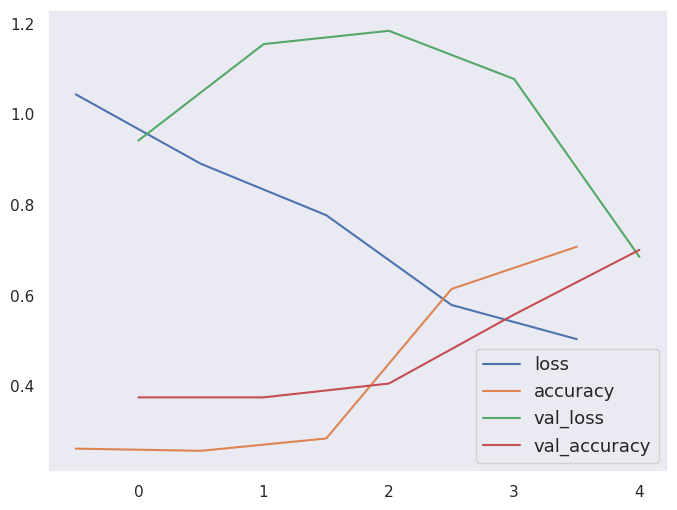

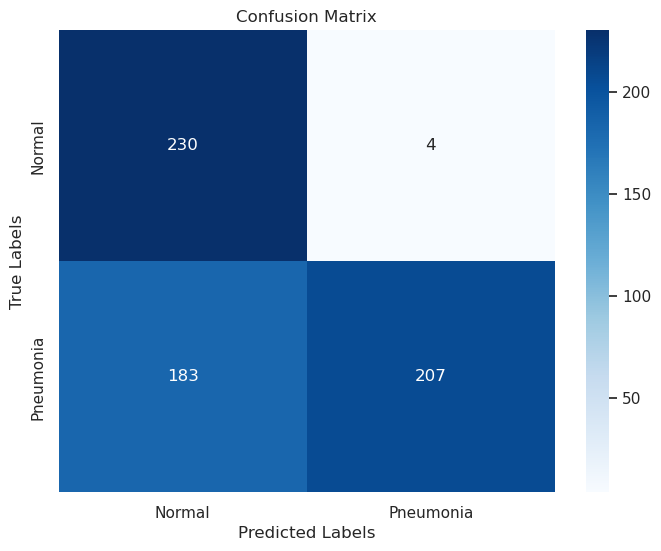

20/20 [==============================] - 0s 9ms/step


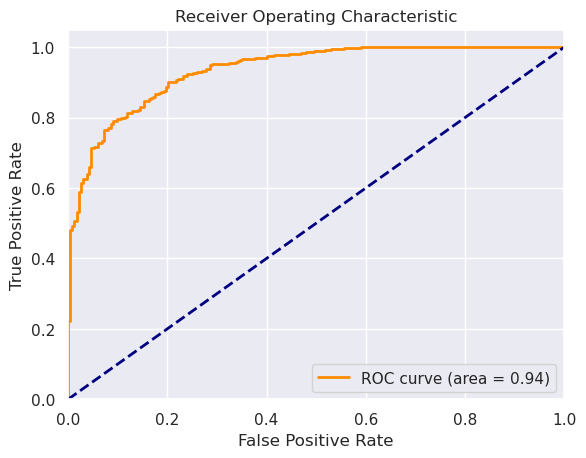

In [8]:
# Train the model
history = model.fit(
    datagen.flow(X_train, y_train_cat, batch_size=batch_size),
    validation_data=(X_test, y_test_cat),
    epochs=epochs,
    verbose=1,
    callbacks=[callback],
    class_weight={0: 6.0, 1: 0.5}
)

#plot learning curves

fig, ax = plt.subplots(figsize=(8,6))

for metric in history.history:
    
    #subtract half epoch from training data
    if len(metric.split('_')) < 2:
        ax.plot(np.array(history.epoch)-.5, history.history[metric], label=metric)
    else:
        ax.plot(history.epoch, history.history[metric], label=metric)
    
ax.grid()    

ax.legend(fontsize=13);


# Confusion matrix

# Effettua previsioni sui dati di test
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

# Calcola la matrice di confusione
conf_matrix = confusion_matrix(y_test, predicted_labels)

# Visualizza la matrice di confusione

class_labels = ["Normal", "Pneumonia"]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Curva di ROC

# Effettua previsioni sui dati di test
predictions = model.predict(X_test)

# Calcola la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, predictions[:, 1])
roc_auc = auc(fpr, tpr)

# Visualizza la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()
